# Preliminary

In [54]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
import sys

import numpy as np
import pickle, random, string
import matplotlib.pyplot as plt
%matplotlib inline

# Visualization
from IPython.display import display

from pathlib import Path

In [55]:
# Ugly patch becasue idk how to make this propperly work
#sys.path[0] += '/Codebase'
sys.path

['/home/jovyan/Extrapolation-Exploration/Codebase',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/lib/python3.9/site-packages']

In [56]:
#my classes
#from testClass import *
from transformerClasses import *
from embeddingClasses import *
from lstmClasses import *
from resourceFunctions import *

# Loading Outer Model

In [57]:
# setting up the pathlib stuff 
path = Path('..')
print([x for x in path.iterdir() if x.is_dir()])

path = path / 'saved-models'
outPath = path / 'OuterTransformer'

encPathJson = outPath / 'encoder_len53.json'
decPathJson = outPath / 'decoder_len53.json'
encPathH5 = outPath / 'encoder_len53.h5'
decPathH5 = outPath / 'decoder_len53.h5'

[PosixPath('../.ipynb_checkpoints'), PosixPath('../saved-models'), PosixPath('../Qualifying-Exam-Writings'), PosixPath('../Codebase'), PosixPath('../Papers'), PosixPath('../data'), PosixPath('../.git')]


In [58]:
with encPathJson.open() as encoder_file, decPathJson.open() as decoder_file:
    encoder_json = encoder_file.read()
    decoder_json = decoder_file.read()
outer_encoder = keras.models.model_from_json(encoder_json,custom_objects={"PositionEmbedding":OuterPositionEmbedding,
                                                                          "TransformerBlock":OuterTransformerBlock,
                                                                          "MaskedTokenAndPositionEmbedding": OuterMaskedTokenAndPositionEmbedding, 
                                                                          "MaskedTransformerBlock":OuterMaskedTransformerBlock})
outer_decoder = keras.models.model_from_json(decoder_json, custom_objects={"PositionEmbedding":OuterPositionEmbedding,
                                                                           "TransformerBlock":OuterTransformerBlock,
                                                                           "MaskedTokenAndPositionEmbedding": OuterMaskedTokenAndPositionEmbedding, 
                                                                           "MaskedTransformerBlock":OuterMaskedTransformerBlock})
outer_encoder.load_weights(encPathH5)
outer_decoder.load_weights(decPathH5)

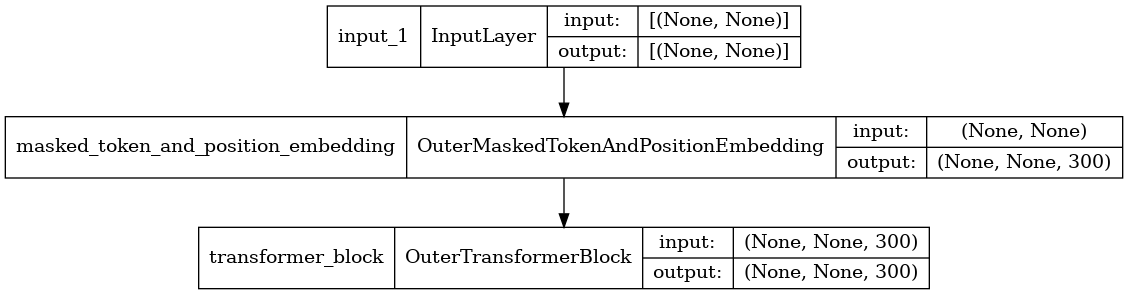

In [59]:
keras.utils.plot_model(outer_encoder, show_shapes=True)

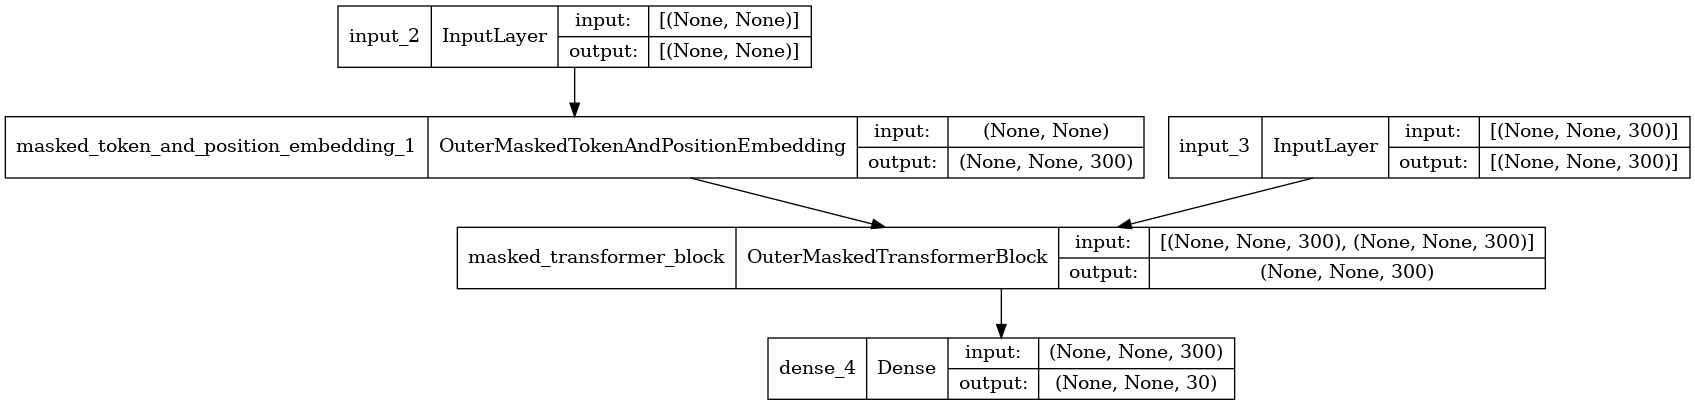

In [60]:
keras.utils.plot_model(outer_decoder, show_shapes=True)

# Load Input Data

In [61]:
corpus = open('../data/len5_10000-train.txt')#corpus = np.loadtxt(sys.argv[1], dtype=object)
corpus = np.loadtxt(corpus, dtype=object)

trainingSet = open('../data/SG-10-train.txt')
testingSet  = open('../data/SG-10-test.txt')

trainingSet = np.loadtxt(trainingSet, dtype=str)
testingSet  = np.loadtxt(testingSet, dtype=str)

In [62]:
length = 10
padded_length = 20

embed_dim = 300 

# Note we are making these the same, but they don't -have- to be!
# input_length = padded_length
# output_length = padded_length

input_length = 5+1
output_length = 5+1

# Vocabulary sizes...
encoder_vocab_size = 30 # blank, a, b, c, ... j (bc/SG-10)
decoder_vocab_size = 30 # blank, a, b, c, ... j, start, stop

In [63]:
X, Y, preY, postY, mapping = letter_to_int(corpus)

In [64]:
print("X.shape=", X.shape)
print("Y.shape=", Y.shape)
print("preY.shape=", preY.shape)
print("postY.shape=", postY.shape)

X.shape= (10000, 5)
Y.shape= (10000, 7)
preY.shape= (10000, 6)
postY.shape= (10000, 6)


# Inner LSTM

In [65]:
encoder_model = outer_encoder
decoder_model = outer_decoder

In [66]:
#sample 10 indices from the coprus WOR
corIdx = np.random.randint(0,high=len(corpus),size=20)
#I could probably just do a np array of size 10000 
corIdx = np.random.choice(corIdx,size=10,replace=False)

outer_x = X[corIdx]
outer_preY = preY[corIdx]
outer_postY = postY[corIdx]

outer_embeddings = outer_encoder.predict(outer_x)

trainingSet_int = letter_to_int(trainingSet)[0]

testingSet_int = letter_to_int(testingSet)[0]

inner_x = np.array([outer_embeddings[trainingSet_int[x]-1] for x in range(len(trainingSet))]) #200 comes from the trainingSet 
inner_x_testing = np.array([outer_embeddings[testingSet_int[x]-1] for x in range(len(testingSet))])


In [67]:
#need testing inner_postY_testing


dog = np.zeros((1,5,300))
dog.shape
np.concatenate((dog, inner_x[0]))

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.13400747e-05,  5.90854557e-03, -4.08202738e-01, ...,
          3.03881534e-05,  2.47141405e-04,  7.16019422e-04],
        [-1.09975250e-03, -4.54675453e-03,  2.14996114e-01, ...,
         -1.28564110e-03, -1.00353442e-03, -1.09294232e-03],
        [ 7.23451260e-04, -5.30217914e-03,  2.26141751e-01, ...,
          3.23375105e-04,  3.48942849e-04,  4.39809

In [68]:
#make inner_postY and outer_postY
dog = np.zeros((1,5,300))
inner_preY = np.array([np.concatenate((dog,inner_x[i])) for i in range(len(inner_x))])
inner_postY = np.array([np.concatenate((inner_x[i],dog)) for i in range(len(inner_x))])


#testing postY and preY
dog = np.zeros((1,5,300))
dog.shape
np.concatenate((dog, inner_x_testing[0]))

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 9.89458524e-04, -1.30448025e-04,  1.20319404e-01, ...,
          8.73981917e-04,  9.57175856e-04,  1.00617565e-03],
        [ 1.16071594e-03, -1.45256857e-03, -2.10353341e-02, ...,
          2.99274689e-04,  5.19169436e-04,  1.38215697e-03],
        [ 3.17115046e-05, -4.93209064e-03, -7.27873370e-02, ...,
         -3.40052473e-04, -4.63821307e-05,  4.42774

In [69]:
dog = np.zeros((1,5,300))
inner_preY_testing = np.array([np.concatenate((dog,inner_x_testing[i])) for i in range(len(inner_x_testing))])
inner_postY_testing = np.array([np.concatenate((inner_x_testing[i],dog)) for i in range(len(inner_x_testing))])

In [70]:
#inner encoder construction 
hidden_size = 300
inner_encoder_input = keras.layers.Input(shape=(None,) + inner_x.shape[2:], name="inner_encoder_input")

#reshape layer here
inner_encoder_reshape = keras.layers.Reshape((-1,1500))(inner_encoder_input)
inner_encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True, name="inner_encoder") #pass layers in here

In [71]:
encoder_output, enc_state_h, enc_state_c = inner_encoder_hidden(inner_encoder_reshape)
encoder_states = [enc_state_h, enc_state_c]

In [72]:
#inner decoder construction
inner_decoder_input_1 = keras.layers.Input(shape=(None,) + inner_preY.shape[2:], name="inner_dec_token_1")
inner_decoder_reshape_layer = keras.layers.Reshape((-1,1500))
inner_decoder_reshape = inner_decoder_reshape_layer(inner_decoder_input_1)
inner_decoder_input_2 = keras.layers.Input(shape=(None, 2), name="dec_start/stop")
inner_decoder_concat_layer = keras.layers.Concatenate()
inner_decoder_concat = inner_decoder_concat_layer([inner_decoder_reshape,inner_decoder_input_2])

inner_decoder_hidden = keras.layers.LSTM(hidden_size,return_sequences=True,return_state=True,name="inner_decoder") #need initial state for h and c

In [73]:
#tie it together 
decoder_hidden_output, decoder_state_h, decoder_state_c = inner_decoder_hidden(inner_decoder_concat,
                                                                         initial_state=encoder_states) #below swap this with new input layerr

In [74]:
# decoder_dense_t1 = keras.layers.Dense(inner_encoder_reshape.shape[-1], activation='linear', name="token_1")(decoder_hidden_output)
# inner_output_reshape = keras.layers.Reshape((-1,inner_postY.shape[2],inner_postY.shape[3]))(decoder_dense_t1)
# decoder_dense_t2 = keras.layers.Dense(2, activation='sigmoid', name="start/stop")(decoder_hidden_output)

In [75]:
inner_output_reshape_layer = keras.layers.Reshape((-1,inner_postY.shape[2], int(embed_dim / inner_postY.shape[2])))

inner_output_reshape = inner_output_reshape_layer(decoder_hidden_output)

decoder_dense_t1_layer = keras.layers.Dense(embed_dim, activation='linear', name="token_1")

decoder_dense_t1 = decoder_dense_t1_layer(inner_output_reshape)

decoder_dense_t2_layer = keras.layers.Dense(2, activation='sigmoid', name="start/stop")
decoder_dense_t2 = decoder_dense_t2_layer(decoder_hidden_output)

In [76]:
inner_decoder_output = [decoder_dense_t1, decoder_dense_t2]

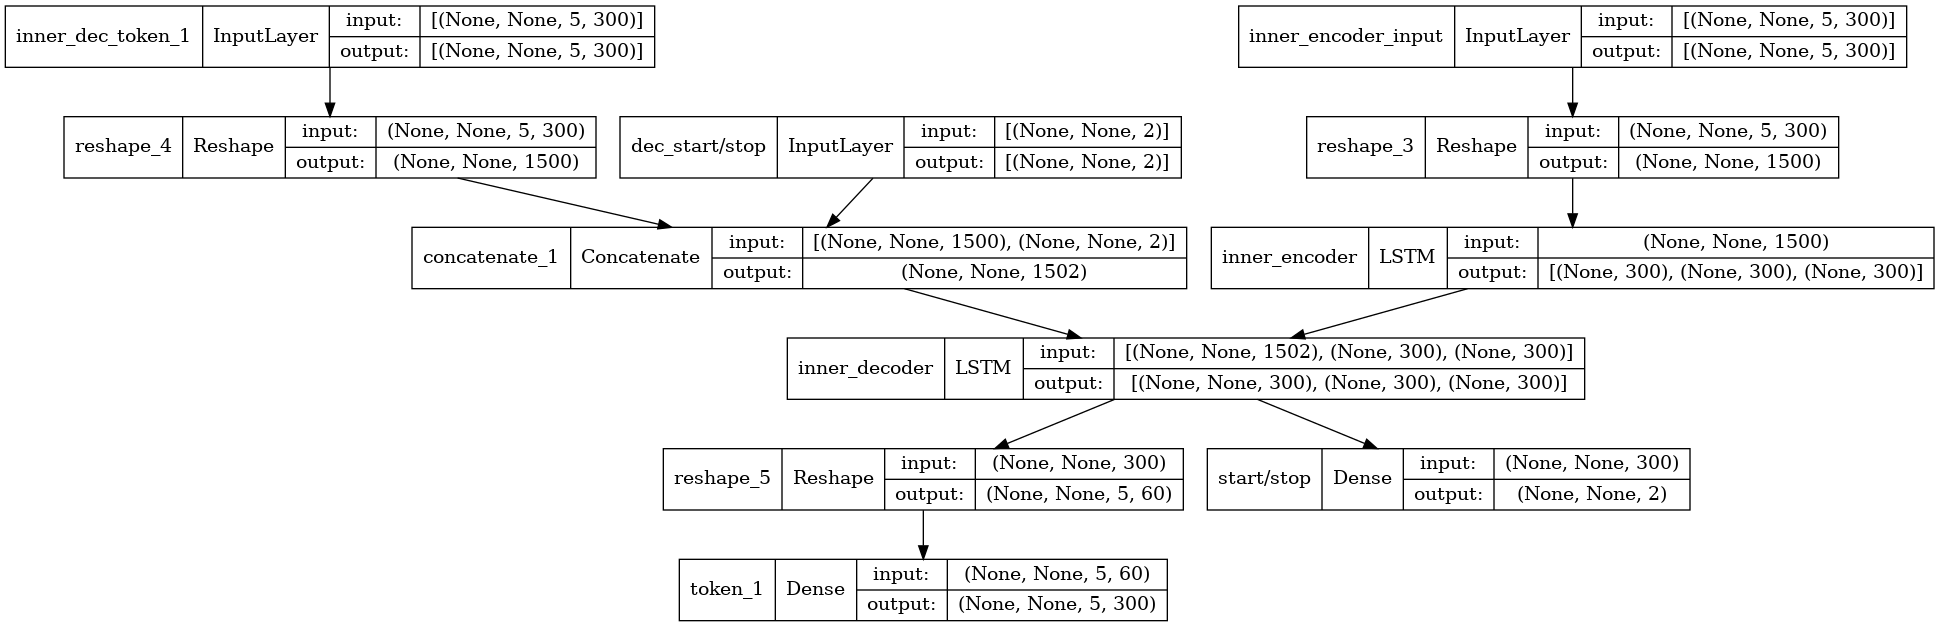

In [77]:
inner_model = keras.Model([inner_encoder_input,inner_decoder_input_1, inner_decoder_input_2],
                         inner_decoder_output)
keras.utils.plot_model(inner_model, expand_nested=True, show_shapes=True)

In [78]:
#make the pre start/stop which will have dimensions (200,4,2)
#pre_start = np.array([[1,0,0,0] for x in range(0,200)])
#is it just the exact same as Blake's
s_s = {"start":[1,0],"stop":[0,1], "none":[0,0]}
pre_start = np.zeros((inner_x.shape[0], 4, 2))
post_stop = np.zeros((inner_x.shape[0], 4, 2))
pre_start[:,0,:] = s_s["start"]
post_stop[:,3,:] = s_s["stop"]

In [79]:
inner_model.compile(loss = [keras.losses.MSE,keras.losses.binary_crossentropy],
               optimizer=keras.optimizers.Adam(),
               metrics=['accuracy'])

In [80]:
inner_model_input = {"input_1":inner_x,"input_2":inner_preY,
                     "dec_start/stop":pre_start}

In [81]:
inner_model_target = {"inner_dec_token_1":inner_postY,"start/stop": post_stop}

In [82]:
#try to train it 
inner_batch_size = 30
inner_epochs = 300
inner_history = inner_model.fit([inner_x,inner_preY, pre_start], [inner_postY,post_stop],
                         batch_size=inner_batch_size,
                         epochs=inner_epochs,
                         verbose=0,
                               validation_data=([inner_x_testing, inner_preY_testing, pre_start[0:100]],[inner_postY_testing, post_stop[0:100]]))

In [83]:
inner_history.history.keys()

dict_keys(['loss', 'token_1_loss', 'start/stop_loss', 'token_1_accuracy', 'start/stop_accuracy', 'val_loss', 'val_token_1_loss', 'val_start/stop_loss', 'val_token_1_accuracy', 'val_start/stop_accuracy'])

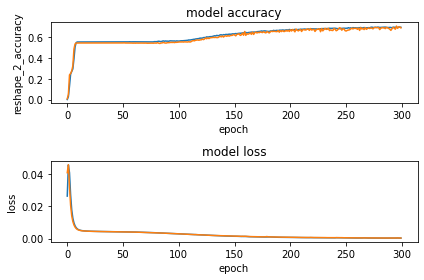

In [84]:
plt.figure(1)  
# summarize history for accuracy 
plt.subplot(211)  
plt.plot(inner_history.history['token_1_accuracy'])  
plt.plot(inner_history.history['val_token_1_accuracy']) 
plt.title('model accuracy')  
plt.ylabel('reshape_2_accuracy')  
plt.xlabel('epoch')  
# summarize history for loss  
plt.subplot(212)  
plt.plot(inner_history.history['token_1_loss'])
plt.plot(inner_history.history['val_token_1_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.tight_layout()
plt.show()  

In [85]:
accuracy = inner_model.evaluate([inner_x,inner_preY, pre_start], [inner_postY,post_stop])

7/7 [==============================] - 0s 11ms/step - loss: 3.1707e-04 - token_1_loss: 3.0696e-04 - start/stop_loss: 1.0105e-05 - token_1_accuracy: 0.6975 - start/stop_accuracy: 0.7500


# Decouple the model

In [86]:
#encoder 
inner_encoder_model = keras.Model(inner_encoder_input, encoder_states)

In [87]:
#Decoder 
inner_decoder_state_input_h = keras.layers.Input(shape=(hidden_size,),
                                                name='inner_states_input_h')

inner_decoder_state_input_c = keras.layers.Input(shape=(hidden_size,),
                                                name='inner_states_input_c')

In [88]:
# Connect hidden to input(s)
inner_decoder_states_input = [inner_decoder_state_input_h,
                             inner_decoder_state_input_c]

inner_decoder_hidden_output, inner_decoder_state_h, inner_decoder_state_c = inner_decoder_hidden(inner_decoder_concat,
              initial_state=inner_decoder_states_input)


inner_decoder_states = [inner_decoder_state_h, inner_decoder_state_c]

inner_output_reshape_2 = inner_output_reshape_layer(inner_decoder_hidden_output)


decoder_dense_t1 = decoder_dense_t1_layer(inner_output_reshape_2)#keras.layers.Dense(inner_encoder_reshape.shape[-1], activation='linear', name="token_1")
decoder_dense_t2 = decoder_dense_t2_layer(inner_decoder_hidden_output)#keras.layers.Dense(2, activation='sigmoid', name="start/stop")

#inner_output_reshape_2 = keras.layers.Reshape((-1,inner_postY.shape[2],inner_postY.shape[3]))(decoder_dense_t1(inner_decoder_hidden_output))

# Connect output to hidden(s)
inner_decoder_output = [decoder_dense_t1, decoder_dense_t2] #maybe a problem is here

In [89]:
inner_decoder_model = keras.Model([inner_decoder_input_1, inner_decoder_input_2] + inner_decoder_states_input,
                                 inner_decoder_output + inner_decoder_states)

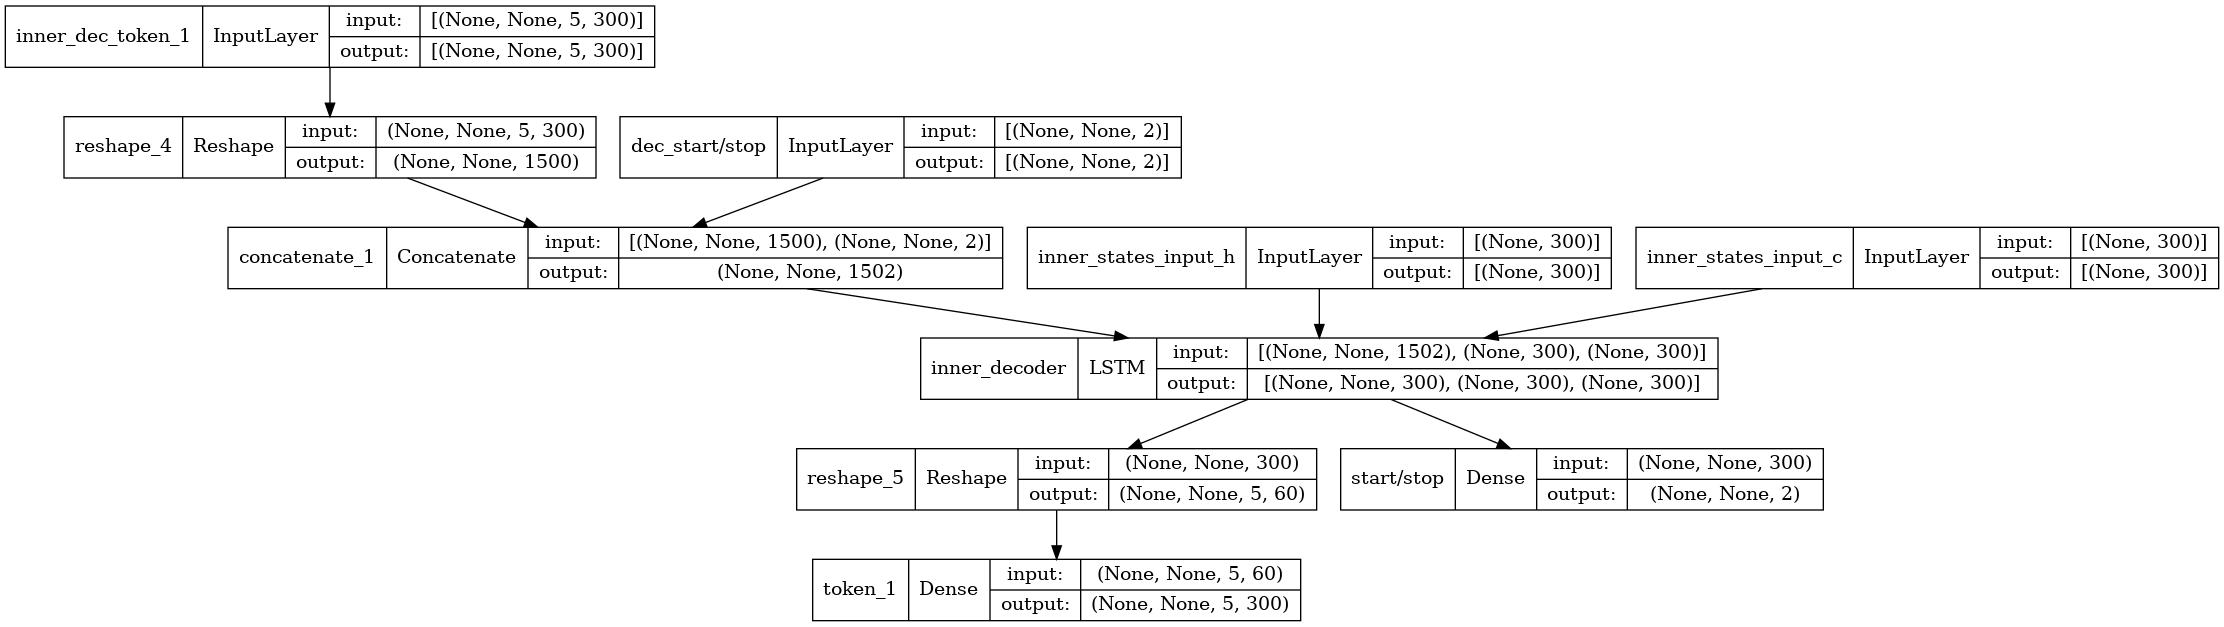

In [90]:
keras.utils.plot_model(inner_decoder_model, expand_nested=True, show_shapes= True)

# Without Teacher Forcing

In [91]:
#get the context
embedding = inner_encoder_model.predict(inner_x[0:1]) 
#without teacher forcing

input_tokens = np.zeros_like(inner_preY[0:1])

input_start = np.zeros_like(pre_start[0:1])

input_start[0,0:1,:] = pre_start[0,0:1,:]


for i in range(0,3): 
    output_tokens = inner_decoder_model.predict([input_tokens, input_start] + embedding)
    
    input_tokens[:,i+1:i+2,:,:] = output_tokens[0][:,i:i+1,:,:] #replace on input_tokens timestep
    input_start[:,i+1:i+2,:] = output_tokens[1][:,i:i+1,:]
    embedding = output_tokens[2:4]
output_tokens = inner_decoder_model.predict([input_tokens, input_start] + embedding)

# Plug inner decoder's output into outer decoder

In [92]:
#teacher forced result 
#output_tokens = inner_model.predict([inner_x[0:1], inner_preY[0:1], pre_start[0:1]])

In [93]:
#output_tokens = [inner_postY[0:1], post_stop[0:1]]


arr = []

for k in range(0,3):
    context = output_tokens[0][0][k:k+1,:,:]
    i=0
    result = np.zeros_like(preY[i:i+1])
    result[0:1,0:1] = preY[i:i+1,0:1] # Start only...

    for j in range(output_length): #ouput length is 5+1 
        tokens = np.argmax(outer_decoder.predict([result,context]),-1)
        result[0:1,j+1:j+2] = tokens[0:1, j:j+1]
            
    result = tokens # Remove start token
    arr.append(int_to_letter(result, mapping)[0])
output = np.asarray(arr)

In [94]:
output

array([['p', 'p', 'p', 'p', 'p', 'stop'],
       ['p', 'p', 'p', 'p', 'p', 'stop'],
       ['p', 'p', 'p', 'p', 'p', 'stop']], dtype='<U4')

In [95]:
check = int_to_letter(outer_postY[trainingSet_int[0]-1], mapping)
check

array([['u', 'y', 'c', 'g', 'k', 'stop'],
       ['g', 'w', 'w', 'b', 'y', 'stop'],
       ['g', 'c', 'c', 'x', 'h', 'stop']], dtype='<U4')

In [96]:
#int_to_letter(outer_x[trainingSet_int[0]-1], mapping)

# Testing

In [97]:
inner_x_testing.shape

(100, 3, 5, 300)

In [98]:
pre_start.shape

(200, 4, 2)

In [104]:
word_acc_arr = []
letter_acc_arr = []
for m in range(0,10): #doing only 5 to save time but should be len(testingSet)
    #get the context
    embedding = inner_encoder_model.predict(inner_x_testing[m:m+1]) 
    #without teacher forcing

    input_tokens = np.zeros_like(inner_preY_testing[m:m+1])

    input_start = np.zeros_like(pre_start[m:m+1])

    input_start[0,0:1,:] = pre_start[m,0:1,:]

    for i in range(0,3):
        
#         output_tokens = inner_decoder_model.predict([input_tokens, input_start] + embedding)

#         input_tokens[:,i+1:i+2,:,:] = output_tokens[0][:,i:i+1,:,:] #replace on input_tokens timestep
#         input_start[:,i+1:i+2,:] = output_tokens[1][:,i:i+1,:]
#         embedding = output_tokens[2:4]
        
        output_tokens = inner_model.predict([inner_x_testing[m:m+1], input_tokens, input_start])
        input_tokens[:,i+1:i+2,:,:] = output_tokens[0][:,i:i+1,:,:] 
        input_start[:,i+1:i+2,:] = output_tokens[1][:,i:i+1,:]
                                       
    output_tokens = inner_model.predict([inner_x_testing[m:m+1], input_tokens, input_start])

    #output_tokens = [inner_postY_testing[m:m+1], post_stop[m:m+1]]
    #output_tokens = inner_decoder_model.predict([input_tokens, input_start] + embedding)
    
    
    #teacher forced result 
    #output_tokens = inner_model.predict([inner_x_testing[m:m+1], inner_preY_testing[m:m+1], pre_start[m:m+1]])
    
    arr = []

    for k in range(0,3):
        context = output_tokens[0][0][k:k+1,:,:]
        #context = inner_postY_testing[m][k:k+1,:,:]
        i=0
        input_tokens = np.zeros_like(preY[i:i+1])
        input_tokens[0:1,0:1] = preY[i:i+1,0:1] # Start only... and m

        for j in range(5): #ouput length is 5+1 
            result = np.argmax(outer_decoder.predict([input_tokens,context]),-1)
            input_tokens[0:1,j+1:j+2] = result[0:1, j:j+1] #0:1 m
        result = np.argmax(outer_decoder.predict([input_tokens,context]),-1) # Remove start token
        arr.append(int_to_letter(result, mapping)[0])

    output = np.asarray(arr)
    #print(output)

    check = int_to_letter(outer_postY[testingSet_int[m]-1], mapping)
    #print(check)

    word_acc_arr.append(word_accuracy(output, check))
    letter_acc_arr.append(letter_accuracy(output, check))

In [105]:
output

array([['s', 'e', 's', 'u', 'z', 'stop'],
       ['j', 'h', 'a', 'j', 'n', 'stop'],
       ['j', 'h', 'a', 'j', 'h', 'stop']], dtype='<U4')

In [106]:
check

array([['s', 'e', 's', 'u', 'z', 'stop'],
       ['j', 'h', 'a', 'j', 'n', 'stop'],
       ['k', 'p', 'd', 'p', 'h', 'stop']], dtype='<U4')

In [107]:
final_word_acc = sum(word_acc_arr) / len(word_acc_arr)

final_letter_acc = sum(letter_acc_arr) / len(letter_acc_arr)

In [108]:
print('''   Generalization Accuracy
-----------------------------
word_accuracy: %f
letter_accuracy: %f
'''%((final_word_acc*100), (final_letter_acc*100)))

   Generalization Accuracy
-----------------------------
word_accuracy: 63.333333
letter_accuracy: 86.666667

